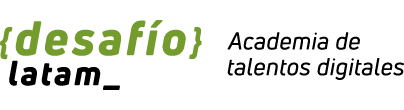

#<center><font color = 'green'>Entrenando un modelo de ensamble paralelo Bagging con árboles de decisión</font></center>

## Importación de librerías y datos - preprocesamiento

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import BaggingRegressor

RANDOM_STATE = 101520

# carga de datos
df = pd.read_csv('insurance.csv')

# generar variables dummies
nom_col = ['sex', 'smoker', 'region'] # variables nominales
con_col = [c for c in df.columns if c not in nom_col] # variables continuas

df_dm = pd.get_dummies(df[nom_col], drop_first=True).astype(int)
df_dm = pd.concat([df_dm, df[con_col]], axis=1).reset_index(drop=True)

# se separan la muestra en entrenamiento y test
X = df_dm.drop(columns=['charges'], axis=1)
y = df_dm['charges']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.33, random_state=RANDOM_STATE)



##Entrenamiento del modelo Bagging

Creamos el modelo Bagging sólo indicando la semilla aleatoria, por defecto entrenará 10 árboles de decisión y posteriormente se muestra información de los clasificadores empleados para este ensamble.


In [ ]:
# se crea el modelo usando 10 estimadores (árboles de decisión)
bagg1_model = BaggingRegressor(random_state=RANDOM_STATE)
bagg1_model.fit(X_train, y_train)

# mostrar datos de cada modelo que componen el ensamble
for idx, i in enumerate(bagg1_model.estimators_):
  print(f'{idx+1} - Tipo: {type(i)}, críterio: {i.criterion}, random_state: {i.random_state}')


1 - Tipo: <class 'sklearn.tree._classes.DecisionTreeRegressor'>, críterio: squared_error, random_state: 629516718
2 - Tipo: <class 'sklearn.tree._classes.DecisionTreeRegressor'>, críterio: squared_error, random_state: 1786987278
3 - Tipo: <class 'sklearn.tree._classes.DecisionTreeRegressor'>, críterio: squared_error, random_state: 1366900406
4 - Tipo: <class 'sklearn.tree._classes.DecisionTreeRegressor'>, críterio: squared_error, random_state: 1853632248
5 - Tipo: <class 'sklearn.tree._classes.DecisionTreeRegressor'>, críterio: squared_error, random_state: 1547068363
6 - Tipo: <class 'sklearn.tree._classes.DecisionTreeRegressor'>, críterio: squared_error, random_state: 1228446316
7 - Tipo: <class 'sklearn.tree._classes.DecisionTreeRegressor'>, críterio: squared_error, random_state: 660663091
8 - Tipo: <class 'sklearn.tree._classes.DecisionTreeRegressor'>, críterio: squared_error, random_state: 137818512
9 - Tipo: <class 'sklearn.tree._classes.DecisionTreeRegressor'>, críterio: squared_

##Predicción del modelo Bagging en los datos de test


In [ ]:
yhat = bagg1_model.predict(X_train)

print('Conjunto de entrenamiento')
print(f'r2: {r2_score(y_train, yhat).round(2)}')
print(f'RMSE: {mean_squared_error(y_train, yhat, squared=False).round(2)}')

yhat = bagg1_model.predict(X_test)
print('\nConjunto de test')
print(f'r2: {r2_score(y_test, yhat).round(2)}')
print(f'RMSE: {mean_squared_error(y_test, yhat, squared=False).round(2)}')


Conjunto de entrenamiento
r2: 0.97
RMSE: 1972.64

Conjunto de test
r2: 0.82
RMSE: 5442.32


El resultado es un 82% de la varianza explicada por el modelo sobre los datos de test y el error en unidades monetaria alcanza 5442,32, es un buen comienzo.

##Análisis del efecto de incrementar la cantidad de clasificadores en Bagging

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_bagging.py:1253: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn(


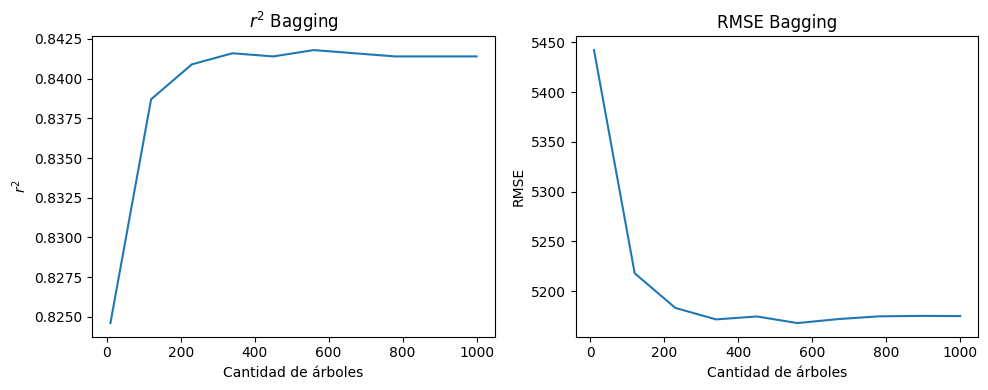

In [ ]:
# se entrena Bagging con 10 cantidades diferentes de clasificadores
# partiendo con 10 y llegando hasta 500
n_est = np.linspace(10, 1000, 10, dtype='int')
df_results = pd.DataFrame({'n_est': [], 'r2': [], 'rmse':[]})

for i in n_est:
    bagg_tmp = BaggingRegressor(
        random_state=RANDOM_STATE, n_estimators=i, oob_score=True,
        n_jobs=-1, bootstrap=True
    )

    bagg_tmp.fit(X_train, y_train)
    yhat = bagg_tmp.predict(X_test)

    r2 = r2_score(y_test, yhat)
    rmse = mean_squared_error(y_test, yhat, squared=False)

    df_results = pd.concat([df_results,
        pd.DataFrame({'n_est': [i], 'r2': [r2.round(4)], 'rmse': [rmse.round(4)]})
    ])


# plots
fig, ax = plt.subplots(ncols=2, figsize=(10, 4))

ax[0].plot(df_results['n_est'], df_results['r2'])
ax[0].set_title(r'$r^2$ Bagging')
ax[0].set_xlabel('Cantidad de árboles')
ax[0].set_ylabel(r'$r^2$')

ax[1].plot(df_results['n_est'], df_results['rmse'])
ax[1].set_title('RMSE Bagging')
ax[1].set_xlabel('Cantidad de árboles')
ax[1].set_ylabel('RMSE')

plt.tight_layout()
plt.show();


Se aprecia que a medida que la cantidad de estimadores en Bagging crece tenemos mejores resultados tanto en el $r^2$ como en RMSE. Se observa que llega un punto en que agregar más no trae beneficios; en este caso con 300 estimadores sería suficiente.

Veremos ahora las predicciones de cada estimador que conforman el ensamble para una observación particular.

In [ ]:
# Se escoge la observación con index en X_test = 974
idx_loc = 974
df_obs = pd.concat([X_test.loc[[idx_loc]], y_test.loc[[idx_loc]]], axis=1)
df_obs


sex_male  smoker_yes  region_northwest  region_southeast  \
974         1           0                 0                 1   

     region_southwest  age    bmi  children    charges  
974                 0   26  35.42         0  2322.6218

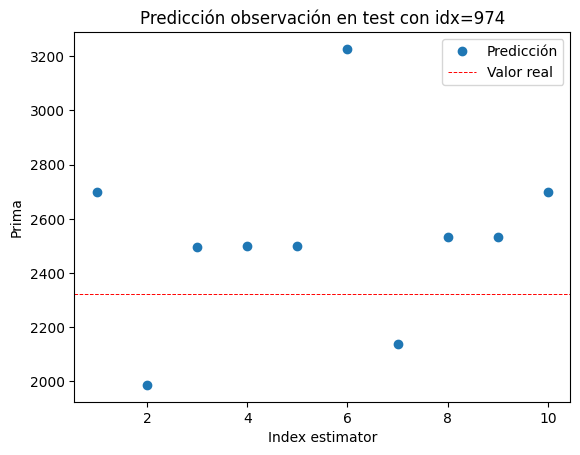

In [ ]:
yhat = []
for idx, est in enumerate(bagg1_model.estimators_):
    yhat.append(est.predict(df_obs.drop(columns=['charges']).values)[0])

plt.plot(list(range(1, len(bagg1_model.estimators_)+1)), yhat, 'o', label='Predicción')
plt.title('Predicción observación en test con idx=974')
plt.axhline(y=df_obs['charges'].values, color='red', lw=0.7, ls='--', label='Valor real')
plt.xlabel('Index estimator')
plt.ylabel('Prima')
plt.legend();


##Evaluación de correlación entre los estimadores

Un problema que afecta notoriamente a los ensambles Bagging es la alta correlación que existe entre sus estimadores. Para medir esto calcularemos la correlación de Pearson entre todos los árboles de decisión que participan en el ensamble de Bagging.


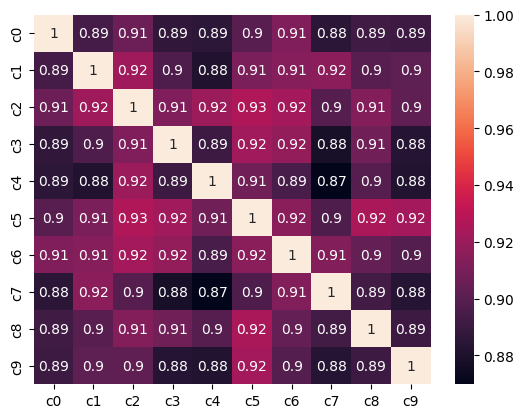

In [ ]:
import seaborn as sns

df_yhat = pd.DataFrame()

for idx, est in enumerate(bagg1_model.estimators_):
    df_yhat_tmp = pd.DataFrame({f'c{idx}': est.predict(X_test.values)})
    df_yhat = pd.concat([df_yhat, df_yhat_tmp], axis=1)

df_corr = df_yhat.corr(method='pearson')
sns.heatmap(data=df_corr, annot=True);


Queda en evidencia en la matriz de correlación la presencia de altas correlaciones entre los estimadores, siendo  todas estas mayores a 0.88. Tener altas correlaciones puede estar indicando que los datos sobre los cuales se entrenan los árboles de decisión son muy parecidos. Para resolver estos problemas es que se da paso al ensamble Random Forest.

## Bagging con modelos heterogéneos
Veremos ahora que la utilización de modelos heterogéneos -es decir, de diferentes tipos- puede ayudar a hacer más eficiente este modelo.

Para trabajar mejor, hemos creado una biblioteca extra llamada util_bagging, que debes cargar en este cuaderno.

In [ ]:
import pandas as pd
import numpy as np
import util_bagging as ubagging


from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from scipy.stats import mode

Utilizaremos una base da datos relacionada con la obesidad.

In [ ]:
df2 = pd.read_csv('ObesityDataSet.csv')
df2.head()

Gender   Age  Height  Weight family_history_with_overweight FAVC  FCVC  \
0  Female  21.0    1.62    64.0                            yes   no   2.0   
1  Female  21.0    1.52    56.0                            yes   no   3.0   
2    Male  23.0    1.80    77.0                            yes   no   2.0   
3    Male  27.0    1.80    87.0                             no   no   3.0   
4    Male  22.0    1.78    89.8                             no   no   2.0   

   NCP       CAEC SMOKE  CH2O  SCC  FAF  TUE        CALC  \
0  3.0  Sometimes    no   2.0   no  0.0  1.0          no   
1  3.0  Sometimes   yes   3.0  yes  3.0  0.0   Sometimes   
2  3.0  Sometimes    no   2.0   no  2.0  1.0  Frequently   
3  3.0  Sometimes    no   2.0   no  2.0  0.0  Frequently   
4  1.0  Sometimes    no   2.0   no  0.0  0.0   Sometimes   

                  MTRANS           NObeyesdad  
0  Public_Transportation        Normal_Weight  
1  Public_Transportation        Normal_Weight  
2  Public_Transportation        Normal_Weight  
3                Walking   Overweight_Level_I  
4  Public_Transportation  Overweight_Level_II

In [ ]:
df2['NObeyesdad'].value_counts()

Obesity_Type_I         351
Obesity_Type_III       324
Obesity_Type_II        297
Overweight_Level_I     290
Overweight_Level_II    290
Normal_Weight          287
Insufficient_Weight    272
Name: NObeyesdad, dtype: int64

In [ ]:
condiciones = [
    df2['NObeyesdad'] == 'Obesity_Type_I',
    df2['NObeyesdad'] == 'Obesity_Type_III',
    df2['NObeyesdad'] == 'Obesity_Type_II',
    df2['NObeyesdad'] == 'Overweight_Level_I',
    df2['NObeyesdad'] == 'Overweight_Level_II',
    df2['NObeyesdad'] == 'Normal_Weight',
    df2['NObeyesdad'] == 'Insufficient_Weight'
]

etiquetas = [
    'Obesity',
    'Obesity',
    'Obesity',
    'Normal',
    'Normal',
    'Normal',
    'Insufficient'
]

df2['NObeyesdad'] = np.select(condiciones, etiquetas, default='Otra condición')
df2.head()

Gender   Age  Height  Weight family_history_with_overweight FAVC  FCVC  \
0  Female  21.0    1.62    64.0                            yes   no   2.0   
1  Female  21.0    1.52    56.0                            yes   no   3.0   
2    Male  23.0    1.80    77.0                            yes   no   2.0   
3    Male  27.0    1.80    87.0                             no   no   3.0   
4    Male  22.0    1.78    89.8                             no   no   2.0   

   NCP       CAEC SMOKE  CH2O  SCC  FAF  TUE        CALC  \
0  3.0  Sometimes    no   2.0   no  0.0  1.0          no   
1  3.0  Sometimes   yes   3.0  yes  3.0  0.0   Sometimes   
2  3.0  Sometimes    no   2.0   no  2.0  1.0  Frequently   
3  3.0  Sometimes    no   2.0   no  2.0  0.0  Frequently   
4  1.0  Sometimes    no   2.0   no  0.0  0.0   Sometimes   

                  MTRANS NObeyesdad  
0  Public_Transportation     Normal  
1  Public_Transportation     Normal  
2  Public_Transportation     Normal  
3                Walking     Normal  
4  Public_Transportation     Normal

In [ ]:
df3 = df2.drop(columns=['CAEC', 'CALC', 'MTRANS'])
df3 = pd.get_dummies(data=df3, columns=['Gender', 'FAVC', 'family_history_with_overweight', 'SMOKE', 'SCC'], drop_first=True)
df3.head()

Age  Height  Weight  FCVC  NCP  CH2O  FAF  TUE NObeyesdad  Gender_Male  \
0  21.0    1.62    64.0   2.0  3.0   2.0  0.0  1.0     Normal            0   
1  21.0    1.52    56.0   3.0  3.0   3.0  3.0  0.0     Normal            0   
2  23.0    1.80    77.0   2.0  3.0   2.0  2.0  1.0     Normal            1   
3  27.0    1.80    87.0   3.0  3.0   2.0  2.0  0.0     Normal            1   
4  22.0    1.78    89.8   2.0  1.0   2.0  0.0  0.0     Normal            1   

   FAVC_yes  family_history_with_overweight_yes  SMOKE_yes  SCC_yes  
0         0                                   1          0        0  
1         0                                   1          1        1  
2         0                                   1          0        0  
3         0                                   0          0        0  
4         0                                   0          0        0

In [ ]:
encoder = LabelEncoder()
df3['NObeyesdad'] = encoder.fit_transform(df2['NObeyesdad'])

df3.head()

Age  Height  Weight  FCVC  NCP  CH2O  FAF  TUE  NObeyesdad  Gender_Male  \
0  21.0    1.62    64.0   2.0  3.0   2.0  0.0  1.0           1            0   
1  21.0    1.52    56.0   3.0  3.0   3.0  3.0  0.0           1            0   
2  23.0    1.80    77.0   2.0  3.0   2.0  2.0  1.0           1            1   
3  27.0    1.80    87.0   3.0  3.0   2.0  2.0  0.0           1            1   
4  22.0    1.78    89.8   2.0  1.0   2.0  0.0  0.0           1            1   

   FAVC_yes  family_history_with_overweight_yes  SMOKE_yes  SCC_yes  
0         0                                   1          0        0  
1         0                                   1          1        1  
2         0                                   1          0        0  
3         0                                   0          0        0  
4         0                                   0          0        0

In [ ]:
X = df3.drop(columns=['NObeyesdad'], axis=1)
y = df3['NObeyesdad']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.33, random_state=24)

In [ ]:
###
# ponderación  para cada clasificador
###

# DecisionTreeClassifier()            -> (25%)
# SVC(kernel='rbf', C=0.2)            -> (25%)
# SVC(kernel='rbf', C=0.2)            -> (25%)
# LogisticRegression(max_iter=10000)  -> (25%)

estimadores = [
    DecisionTreeClassifier(),
    SVC(kernel='rbf', C=0.2),
    SVC(kernel='sigmoid', C=2.3),
    LogisticRegression(max_iter=10000)
]

lst_estimadores, result1, yhat, idx_oob = ubagging.bagging_het(X_train, y_train, 50, estimadores, X_test)

# métricas
print(classification_report(y_test, yhat))

              precision    recall  f1-score   support

           0       0.88      0.96      0.92        91
           1       0.95      0.91      0.93       278
           2       0.96      0.97      0.97       328

    accuracy                           0.95       697
   macro avg       0.93      0.95      0.94       697
weighted avg       0.95      0.95      0.95       697



In [ ]:
###
# ponderación  para cada clasificador
###

# DecisionTreeClassifier()            -> (60%)
# SVC(kernel='rbf', C=0.2)            -> (20%)
# LogisticRegression(max_iter=10000)  -> (20%)

estimadores = [
    DecisionTreeClassifier(),
    DecisionTreeClassifier(),
    DecisionTreeClassifier(),
    SVC(kernel='rbf', C=0.2),
    LogisticRegression(max_iter=10000)
]

lst_estimadores, result1, yhat, idx_oob = ubagging.bagging_het(X_train, y_train, 50, estimadores, X_test)
print(classification_report(y_test, yhat))

              precision    recall  f1-score   support

           0       0.98      0.97      0.97        91
           1       0.98      0.97      0.98       278
           2       0.98      0.99      0.99       328

    accuracy                           0.98       697
   macro avg       0.98      0.98      0.98       697
weighted avg       0.98      0.98      0.98       697



Podemos observar un interesante rendimiento al utilizar diferentes modelos.